**<p style="text-align: center;"><span style="background-color: #FFFF00"><font size= "8" color = "red">US Accidents</font></span></p>**

# Introduction
- US-Accidents: A Countrywide Traffic Accident Dataset
- Published: July 2020
**Description**
This is a countrywide traffic accident dataset, which covers 49 states of the United States. The data is continuously being collected from 2016, using several data providers, including two APIs which provide streaming traffic event data. These APIs broadcast traffic events captured by a variety of entities, such as the US and state departments of transportation, law enforcement agencies, traffic cameras, and traffic sensors within the road-networks. Currently, there are about 3.5 million accident records in this dataset

<img src="https://mklstatic01.azureedge.net/~/media/specialty/2018-web/defensive-driving/dangerous-road-conditions.jpg?h=400&w=600&rev=5c1c7bcbafdf4e99987eed815602b635&hash=6F0ADD8C0CB16036F1031BB94B830C12" alt="Image"
        title="Severe weather condition" width=500 />

## Purpose of Analysis
The primary purpose of this analysis is to understand if there are any pattern about car accidents across the US, in terms of time, location, weather, nearby facilities and the day period (data/night)

## Read and understand the data

In [1]:
import pandas as pd
import dask.dataframe as dd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set

<function seaborn.rcmod.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)>

In [2]:
import plotly.graph_objects as go
import cufflinks as cf
from plotly.offline import iplot
%matplotlib inline
cf.go_offline(connected=True)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
df = dd.read_csv('US_Accidents_June20.csv',
                parse_dates = ["Start_Time", "End_Time"]).set_index("ID")

In [4]:
#drop some columns that are not used for analysis and columns that have many null values ("Precipitation", "Wind_Chill(F)")
df =  df.drop(["Source", "TMC", "End_Lat","End_Lng", "Distance(mi)", "Description", "Number", "Street", "Side", "City",
               "Weather_Timestamp", "Zipcode", "Timezone", "Airport_Code","Country","Precipitation(in)", "Wind_Chill(F)",
               'Start_Lng'],
       axis = 1)

## Data cleaning
We clean the data based on 3 conditions:
- Duplicated values
- Null values 
- Inappropriate values

In [5]:
df = df.drop_duplicates()

In [6]:
null_values = df.isnull().compute()

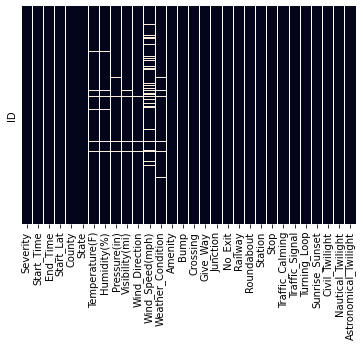

In [7]:
sns.heatmap(null_values, cbar = False, yticklabels=[])

In [8]:
df = df.drop(["Wind_Speed(mph)"], axis=1)

In [9]:
df = df.dropna()

In [10]:
df['Accident_Duration'] = df.End_Time - df.Start_Time

In [11]:
df.Accident_Duration = df.Accident_Duration.dt.total_seconds()/3600

In [12]:
df.Accident_Duration.describe().compute()

count    3.375748e+06
mean     1.806103e+00
std      4.518479e+01
min     -5.680556e-01
25%      4.955556e-01
50%      7.444444e-01
75%      1.247222e+00
max      2.369926e+04
Name: Accident_Duration, dtype: float64

In [12]:
df = df.loc[df.Accident_Duration > 0]

In [13]:
df = df.drop(["Accident_Duration", "End_Time"], axis = 1)

In [15]:
df.compute().shape

(3375726, 28)

## Attributes Description

| Column |   Description|
| :- | :- |
| ID| This is a unique identifier of the accident record. |
| Severity | Shows the severity of the accident, a number between 1 and 4, where 1 indicates the least impact on traffic (i.e., short delay as a result of the accident) and 4 indicates a significant impact on traffic (i.e., long delay). |
| Start_Time | Shows start time of the acciden |
| End_Time| Shows end time of the accident in local time zone. End time here refers to when the impact of accident on traffic flow was dismissed. |
| County | Shows the county in address field. |
| State | Shows the state in address field. |
| Temperature(F) | Shows the temperature (in Fahrenheit). |
| Humidity(%) | Shows the humidity (in percentage). |
| Pressure(in) | Shows the air pressure (in inches). |
| Visibility(mi) | Shows visibility (in miles). |
| Weather_Condition | Shows the weather condition (rain, snow, thunderstorm, fog, etc.)|
| Amenity | A POI annotation which indicates presence of amenity in a nearby location |
| Bump | A POI annotation which indicates presence of speed bump or hump in a nearby location |
| Crossing | A POI annotation which indicates presence of crossing in a nearby location |
| Give_Way | A POI annotation which indicates presence of give_way in a nearby location |
| Junction | A POI annotation which indicates presence of junction in a nearby location|
| No_Exit | A POI annotation which indicates presence of no_exit in a nearby location |
| Railway | A POI annotation which indicates presence of railway in a nearby location |
| Roundabout | A POI annotation which indicates presence of roundabout in a nearby location |
| Station | A POI annotation which indicates presence of station in a nearby location |
| Stop | A POI annotation which indicates presence of stop in a nearby location|
| Traffic_Calming | A POI annotation which indicates presence of traffic_calming in a nearby location |
| Traffic_Signal | A POI annotation which indicates presence of traffic_signal in a nearby location |
| Turning_Loop | A POI annotation which indicates presence of turning_loop in a nearby location. |
| Sunrise_Sunset| Shows the period of day (i.e. day or night) based on sunrise/sunset|
| Civil_Twilight | Shows the period of day (i.e. day or night) based on civil twilight |
| Nautical_Twilight | Shows the period of day (i.e. day or night) based on nautical twilight |
| Astronomical_Twilight| Shows the period of day (i.e. day or night) based on astronomical twilight. |

## Analysis

### Accidents over time and locations

In [14]:
df_time_loc = df.loc[:,"Severity":"State"]

In [15]:
df_time_loc

,Severity,Start_Time,Start_Lat,County,State
npartitions=1,,,,,
,int64,datetime64[ns],float64,object,object
,...,...,...,...,...


In [16]:
df_time_loc = df_time_loc.assign(year = df_time_loc.Start_Time.dt.year,
                   month = df_time_loc.Start_Time.dt.month,
                   weekday = df_time_loc.Start_Time.dt.weekday,
                   hour = df_time_loc.Start_Time.dt.hour)

In [17]:
df_time_loc_2019 = df_time_loc.loc[df_time_loc.year < 2020]

In [18]:
df_time_loc_2019 = df_time_loc_2019.categorize(columns = ["Severity",
       'County', 'State', 'year', 'month', 'weekday', 'hour'])

In [19]:
year_data = df_time_loc_2019.pivot_table(index = "year", columns = "Severity", values = "Start_Lat", aggfunc = "count")

In [20]:
year_data_plotting = year_data.compute()

In [21]:
year_data_plotting.index = year_data_plotting.index.astype(int)

In [22]:
year_data_plotting = year_data_plotting.sort_index()

In [25]:
year_data_plotting.iplot(layout = dict(title = "Figure 1: Accidents over years",
                                       xaxis=dict(title = "Years",tickmode="array",tickvals = year_data_plotting.index),
                                      height = 1000,
                                      ))

<div style='background-color:navy; color:white; padding:20px'>
    Figure 1 shows that the total number of accidents increase over time. Yet, the number of the least and most severe accidents kept unchanged. The medium serious accidents (2) went up while the highly serious one (3) went down.
</div>

In [26]:
month_data = df_time_loc_2019.pivot_table(index = "month", columns = "Severity", values = "Start_Lat", aggfunc = "count")
month_data.compute().iplot(kind = "bar",
                           yTitle = "Month",
                           xTitle = "Accidents by Severity",
                           title = "Figure 2: Accidents by month")

<div style='background-color:navy; color:white; padding:20px'>
    Figure 2 shows that the total number of accidents significantly increased in the last 5 months of the year (from Aug to Dec) , reaching its peak in Oct. It might be because of the winter starting from Oct.
</div>

In [27]:
weekday_data = df_time_loc_2019.pivot_table(index = "weekday", columns = "Severity", values = "Start_Lat", aggfunc = "count")
weekday_data.compute().iplot(kind = "bar",
                           yTitle = "Weekday",
                           xTitle = "Accidents by Severity",
                           title = "Figure 2: Accidents by weekday")

<div style='background-color:navy; color:white; padding:20px'>
    <li> Figure 3 indicated that there are more accidents during weekday (Mon_Fri), compared to during weekend because people are supposed to use cars more during weekday to school or to work.
    <li> However, on Sat and Sun, the percentage of the highly serious accidents (level 3) is higher than that of normal weekday 
</div>

In [ ]:
hour_data = df_time_loc_2019.pivot_table(index = "hour", columns = "Severity", values = "Start_Lat", aggfunc = "count")
hour_data.compute().iplot(kind = "bar",
                           yTitle = "Accidents by Severity",
                           xTitle = "Hour",
                           title = "Figure 2: Accidents by hours")

<div style='background-color:navy; color:white; padding:20px'>
    Figure 4 indicated that there are more accidents around 7-8 am, followed by 4-5pm every day. Those are the times that people are supposed to go to and back from school or work.
</div>

#### Accidents by States

In [23]:
state_data_groupby = df_time_loc_2019.groupby("State").Severity.count()

In [24]:
state_data_plotting = state_data_groupby.reset_index()

In [25]:
state_data_plotting = state_data_plotting.compute(scheduler="multiprocessing")

In [26]:
data = dict(type = "choropleth",
           colorscale = "Greens",
           locations = state_data_plotting["State"],
            z = state_data_plotting["Severity"],
            locationmode = "USA-states",
            marker = dict(line = dict(color = "rgb(255,255,255)", width = 2)),
            colorbar = {"title": "Cases"}
           )

In [27]:
layout = dict(title = "US accidents by State",
             geo = dict(scope = "usa",
                       showlakes = True,
                       lakecolor = "rgb(85,173,240)")
             )

In [28]:
choromap = go.Figure(data =[data], layout = layout)

In [29]:
iplot(choromap)

<div style='background-color:navy; color:white; padding:20px'>
    Figure 5 showed the the top 3 states that have most car accidents are CA (California), followed by TX (Texas) and FL(Florida). Those states are also the top 3 states that have the highest population in the US, confirming by this link:
    https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population
</div>

In [30]:
df_time_loc_2019.Severity = df_time_loc_2019.Severity.astype(int)

In [31]:
state_data_severity = df_time_loc_2019.groupby("State").Severity.mean().reset_index()

In [32]:
state_data_severity_plotting = state_data_severity.compute(scheduler='multiprocessing')

In [33]:
data_ = dict(type = "choropleth",
           colorscale = "Reds",
           locations = state_data_severity_plotting["State"],
            z = state_data_severity_plotting["Severity"],
            locationmode = "USA-states",
            marker = dict(line = dict(color = "rgb(255,255,255)", width = 2)),
            colorbar = {"title": "Severity Level"}
           )

In [34]:
layout_ = dict(title = "US accidents by State",
             geo = dict(scope = "usa",
                       showlakes = True,
                       lakecolor = "rgb(85,173,240)")
             )

In [35]:
choromap_ = go.Figure(data =[data_], layout = layout_)

In [36]:
iplot(choromap_)

<div style='background-color:navy; color:white; padding:20px'>
    <li> However, interestingly, as shown in Figure 6, the mean of severity level in SD (South Dakota) and WY (Wyoming) are highest among the US. More severe accidents happened in those two states. 
    <li> But if those two states are not taken into consideration, generally, more severe accidents happened in the Eastern of the US, compared to the Western one. 
</div>

In [38]:
county_data_pivot = df_time_loc_2019.pivot_table(index = "month", columns = "County", values = "Severity", aggfunc="count")

In [39]:
county_data_pivot = county_data_pivot.compute(scheduler='multiprocessing')

In [40]:
county_data_pivot.index = county_data_pivot.index.astype(int)

In [41]:
county_data_pivot = county_data_pivot.sort_index()

In [42]:
def plot_by_county(County):
    fig = county_data_pivot[County].iplot(kind = "bar",
                                    layout = dict(
                                    title = "Number of accidents")
    )

In [43]:
interact(plot_by_county, County = county_data_pivot.columns)

interactive(children=(Dropdown(description='County', options=('Montgomery', 'Franklin', 'El Dorado', 'Yolo', '…

<function __main__.plot_by_county(County)>

### Weather conditions and Accidents

#### Purpose of Analysis
Primary purpose of analysing this dataset is to find the relation between the weather condition and accidents. This analysis is based on the US datasets, centered within the states of US. We believe that this topic of analysis, will gives us clear view regarding the following questions.
1. To which extent the weather conditions much contributes in the accidents.
2. Which weather is considered to be good or bad regarding the accidents.
3. To understand anykind of trend between the weather attributes, time and accident.
4. Relation between the Severity Level of accident and Weather factors.


In [44]:
data = dd.read_csv("clean.csv",parse_dates = ["Start_Time", "End_Time"])

In [45]:
data = data.set_index("ID")

In [46]:
required_cols = ["Severity", "Start_Time","Start_Lat", "Start_Lng", "County", "State", 'Temperature(F)', 
                "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Direction",
                "Weather_Condition"]

In [47]:
data1 = data[required_cols]

In [48]:
data1

,Severity,Start_Time,Start_Lat,Start_Lng,County,State,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Weather_Condition
npartitions=13,,,,,,,,,,,,
A-1,int64,datetime64[ns],float64,float64,object,object,float64,float64,float64,float64,object,object
A-1261952,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
A-967705,...,...,...,...,...,...,...,...,...,...,...,...
A-999999,...,...,...,...,...,...,...,...,...,...,...,...


#### Data Sumary

In [49]:
data1.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 12 entries, Severity to Weather_Condition
dtypes: datetime64[ns](1), object(4), float64(6), int64(1)

In [50]:
description = data1.compute().describe()

In [51]:
description.iloc[:,[0,3,4,5,6]]

,Severity,Temperature(F),Humidity(%),Pressure(in),Visibility(mi)
count,3.402734e+06,3.402734e+06,3.402734e+06,3.402734e+06,3.402734e+06
mean,2.338176e+00,6.196703e+01,6.513355e+01,2.974581e+01,9.122390e+00
std,5.510958e-01,1.860003e+01,2.274918e+01,8.278789e-01,2.870044e+00
min,1.000000e+00,-2.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,5.000000e+01,4.900000e+01,2.973000e+01,1.000000e+01
50%,2.000000e+00,6.400000e+01,6.700000e+01,2.995000e+01,1.000000e+01
75%,3.000000e+00,7.590000e+01,8.400000e+01,3.009000e+01,1.000000e+01
max,4.000000e+00,1.706000e+02,1.000000e+02,5.774000e+01,1.400000e+02


#### Correlation

In [52]:
data_par1_corr = data1.compute().corr()

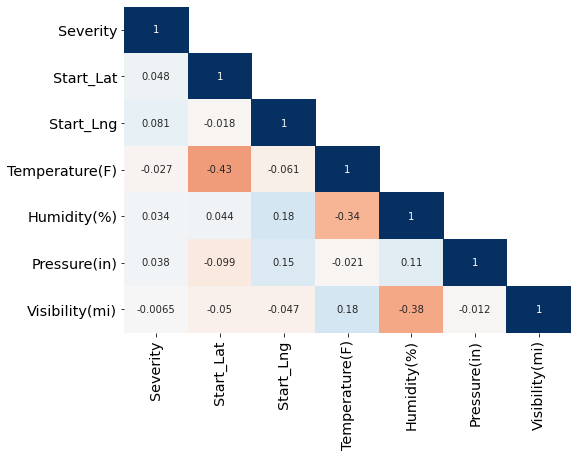

In [53]:
mask = np.triu(np.ones_like(data_par1_corr), k=1)
plt.figure(figsize=(8,6))
sns.heatmap(data_par1_corr, vmin=-1, vmax=1, cbar=False,
                cmap='RdBu',mask=mask, annot=True)
plt.xticks(rotation=90, size='x-large')
plt.yticks(rotation=0, size='x-large')
plt.show()

### Grouping by with Severity Level

In [54]:
g_severity = data1.groupby("Severity").mean().compute()

In [55]:
g_severity.iloc[:,2:].iplot(kind = "bar", title="Mean value of Attributes According to Severity Level", yTitle="Values",
                            xTitle="Severity Level", opacity=0.6)

<div style='background-color:navy; color:white; padding:20px'>
    <li> For the severity level 1, mean temperature is higher than severity level 4
    <li> For hiher severity level mean humidity is slightly higher.
    <li> Mean pressure and visibility has no change over the severity level of accidents.
</div>

#### Time_series

In [56]:
month_g = data1.set_index("Start_Time",drop=True)
month_gr = month_g.resample("MS")
acc_timeseries = month_gr.count().Severity.compute()
month_df = month_gr.mean()
month_df["Accident_Count"] = acc_timeseries
dfm = month_df.compute()

In [57]:
dfm.iloc[:,3:8].iplot(kind="line", title = "Weather Attributes and Relation", xTitle="Time",
                      yTitle="Monthly mean of Weather attributes",secondary_y="Accident_Count",
         secondary_y_title="No.of Accident")

<div style='background-color:navy; color:white; padding:20px'>
    Purpose of this graph is to find the relatable trend. But the trend doesnot show clear relation between the attributes and number of accident.
    <li> initially experience the rise in temperature and accident count. But later the trend doesnot follow.
    <li> Trend of humidity remains at the same level with little fluctuation while the accident count goes on increasing.
    <li> The trend of pressure and visibility is not comparable for this study for the accident count because it remains same throughout the trend
</div>

#### Monthly findings

In [58]:
with_tim = data1.assign(year = data1.Start_Time.dt.year,
                   month = data1.Start_Time.dt.month,
                   weekday = data1.Start_Time.dt.weekday,
                   hour = data1.Start_Time.dt.hour)
with_time = with_tim[with_tim.year < 2020]

In [59]:
monthy_stats = with_time.groupby("month")
acc_counts = monthy_stats.count().Severity.compute()
m_m = monthy_stats.mean().compute()
m_m["acc_counts"] = acc_counts

In [60]:
m_m.iloc[:,[3,4,5,6,10]].iplot(kind="bar", title = "Monthly Preview of Accident and Weather Attributes", xTitle="Months",
         yTitle="Mean of Monthly Summation", secondary_y="acc_counts",secondary_y_title="Month-Wise accident count",
         opacity=0.5)

<div style='background-color:navy; color:white; padding:20px'>
    The graph shows monthly variation of weather attributes to the number of accidents.
    <li> Last four month of the year in which the temperatur is dropping and humidity is increasing, we will find in the rise in the number of accident
</div>

#### Weather Condition

In [61]:
weather_stats = with_time.groupby("Weather_Condition")
acc_count = weather_stats.count().Severity.compute()
w_m = weather_stats.mean().compute()
w_m["acc_count"] = acc_count

In [62]:
w_m["acc_count"].iplot(kind="bar", title = "Weather condition and Accidents", xTitle="Weather conditions",
         yTitle="No.of Accidents",
         opacity=0.5)

<div style='background-color:navy; color:white; padding:20px'>
    The figure shows that, majority of accidents happened in clear and fair weather condition
</div>

#### wind direction

In [63]:
wind_dir = []
for i in data1.Wind_Direction:
    if i == "CALM":
        a= "Calm"
        wind_dir.append(a)
    elif i == "East":
        b= "E"
        wind_dir.append(b)
    elif i == "North":
        c = "N"
        wind_dir.append(c)
    elif i == "NNE":
        d = "NE"
        wind_dir.append(d)
    elif i == "NNW":
        e = "NW"
        wind_dir.append(e)
    elif i == "South":
        f = "S"
        wind_dir.append(f)
    elif i == "SSE":
        g = "SE"
        wind_dir.append(g)
    elif i == "SSW":
        h = "SW"
        wind_dir.append(h)
    elif i == "West":
        j = "W"
        wind_dir.append(j)
    elif i == "Variable":
        k = "VAR"
        wind_dir.append(k)
    else:
        wind_dir.append(i)
        
wind_dir1 = pd.DataFrame(wind_dir)
reindex = data1.reset_index()
wind_di = reindex.join(wind_dir1)

In [64]:
wind_direction = wind_di.groupby(0)
acci_count = wind_direction.count().Severity.compute()
wi_d = wind_direction.mean().compute()
wi_d["acci_count"] = acci_count
wi_d=wi_d.drop(labels = "VAR")

In [65]:
wi_d["acci_count"].iplot(kind="bar", title = "Wind Direction and Accidents", xTitle="Wind Direction",
         yTitle="No.of Accidents",
         opacity=0.5)

<div style='background-color:navy; color:white; padding:20px'>
    The figure shows that, majority of accidents happened during calm wind condition followed by south-west wind.
</div>

#### Conclusion

Our analysis concludes that, there is not significant affect of weather attributes towards the accident occure in United States. Although, weather attributes shows positive relation with the accidents count, but the affect level is low. The severity level of accident also seems to have low effect from weather attributes. We have strong doubt that these accidents might carry strong relationship with other attributes like increase in population, high sales of vehicles, geographical area.  

### Accidents based on Infrastructer and Severity

In [66]:
dff = data[['Severity', 'State', 'Amenity', 'Bump',
                        'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
                        'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']]

#### Analysis of US accident on the basis of Infrastructure , State and Severity

**Main Objective**
- Total count of accidents based on infrastructure(total) by state
- Total count of Accident based on infrastructure by Severity Level
- Total count of Accident by Infrastructure 
- Total count of Accidents on the basis of Severity by state (1 being least impacted and 4 being most impacted )
- Total count of most impactful accident on the basis of state
- Total count of Accident on basis of infrastructure(indivdual) by state 

1. Total count of  accidents based on infrastructure by state  

    Analyzing the difference in Total accidents and accidents related with the presence of infrastructure by State (*Number of Total Accident chart by state  is presented  above*)

In [67]:
Total_traffic= dff.groupby('State')[[  'Amenity', 'Bump',
                        'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
                        'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']].sum()
Total_traffic= Total_traffic.sum(axis=1)


In [68]:
Total_traffic.compute().iplot(
                    kind="bar",
                    yTitle="no of accident",
                    xTitle="State",
                    linecolor="white",
                    title="Total count of  accidents based on infrastructure by state ", theme='pearl',
            
    )


<div style='background-color:navy; color:white; padding:20px'>
We can see huge difference in the number of accidents as whole by state and accidents due to presence of infrastructure nearby. California has nearly three times less  and North Dakota has 6 times less accidents compared to the total accidents as a whole. This may be of the reason of  infrastructure that helps to reduce accident. But looking at the number, more infrastructures could be planned in order to reduce the accident. 
</div>

2. Total count of Accident based on infrastructure by Severity Level

In [69]:
grp_sev = dff.groupby('Severity').sum()
grp_sev.compute().iplot(kind = "bar", title="Total count of Accident based on infrastructure by Severity Level", yTitle="Values",
                            xTitle="Severity Level", opacity=0.6,linecolor="black")


<div style='background-color:navy; color:white; padding:20px'>
Looking at the figure, most of the accident are second level of severity(i.e. moderate).It is difficult to conclude whether the infrastructure is still less or it has not much effect on the moderate level of severity. For moderate to most  impactful severity, there's presence of high number of Traffic Signal and Junction nearby. Accidents nearby Traffic signal and juntions are often the result of not following the Traffic rules. There may be the need of more awareness on Traffic rules to reduce the accident along with its severity.
</div>

3. Total count of Accident by Infrastructure wise

In [70]:
grp_sev.sum(axis=0).compute().iplot(kind = "bar", title="Total count of Accident by Infrastructure wise", yTitle="Values",
                            xTitle="Infrastructure", opacity=0.6, linecolor = 'black')

<div style='background-color:navy; color:white; padding:20px'>
From the above figure, we can see that presence of traffic signal is the highest when the accident occured.Junction and Crossing are second and third highest. Often Traffic Signal and Crossing are regarded highly in reducing the accident but the graph shows otherwise. 
</div>

4. Total count of Accidents on the basis of Severity by state (1 being least impacted and 4 being most impacted )

In [71]:
dff = dff.reset_index()

In [72]:
df_b = dff.compute().pivot_table(index=["State","Severity"], values="ID", aggfunc = "count").reset_index()

In [73]:
df_b.Severity = df_b.Severity.astype(str)

In [74]:
import plotly.express as px
fig= px.bar(df_b, y = 'ID', x = 'State', color = 'Severity',
             labels = {'ID': 'number of accidents',
                        'State': 'State'},
             title = 'Total count of Accidents on the basis of Severity by state',
            color_discrete_sequence = px.colors.qualitative.Pastel,
            category_orders = {'Severity' : [1,2,3,4]})
fig.show()

<div style='background-color:navy; color:white; padding:20px'>
California has the highest count of accidents in all severity level except 1 level of severity(minor). Arizona has the highest count of minor accidents. Texas and Florida comes second and third in terms of count of 2 and 3 level of severity. There are number of states which have very less accidents in all severity level. for e.g DC, Delaware, South Dakota e.t.c  
    
</div>

5. Total count of most impactful accident on the basis of state

In [75]:
most_impact_acc= dff[dff.Severity==4].groupby('State').State.count().compute()


In [76]:
most_impact_acc.iplot(kind='bar', title="Total count of most impactful accident on the basis of state", yTitle="Values",
                            xTitle="State", opacity=0.6, linecolor = 'black')

<div style='background-color:navy; color:white; padding:20px'>
Most Impactful accidents are often considered to be of grave injury to fatality. Florida leads tally in total count of most impactful accidents on the basis of state. It has 8636 cases of most severe accidents. And North Dakota has only 10 cases of such instance. California, Florida, Georgia, Michigan, Newyork, Ohio, Pennsylvenia and Virginia have more than 5000 cases of most impactful accidents whereas Alabama, Arkkansas, DC, Delaware, Kansas, Kentucky, Massachusetts, Minnesota, Mississippi, Nebraska and e.t.c have lower than 1000 cases.
</div>

6. Total count of Accident on basis of infrastructure nearby by state 

In [77]:
Inf_st_sev = dff.groupby('State')[[ 'Amenity', 'Bump',
                        'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
                        'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']].sum()

In [78]:
chart = Inf_st_sev.compute().T

In [79]:
def infrastructure_by_state_severity(State):
    fig = chart[State].iplot(kind = 'bar',
                             layout = dict(
                             title = 'Total count of Accident on basis of infrastructure nearby by state  ' ))

In [80]:
interact(infrastructure_by_state_severity, State = chart.columns)

interactive(children=(Dropdown(description='State', options=('AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', '…

<function __main__.infrastructure_by_state_severity(State)>

<div style='background-color:navy; color:white; padding:20px'>
Presence of Traffic Signal nearby is highest for number of accidents in most of the states. The difference between the count of Traffic Signal and other attributes are quite large for many states. But California being exception to the genral observation, it has count of junction much higher than other attributes. It may be due to the presence of high number of junction and less strict traffic rules.
</div>

**Summary**
We may have various conclusion on the basis of attributes used. From our attributes, the order of state change slightly if we take account of  
total accident by state and total accident by presence of infra-structure.  
By Total Count:  
1. California  
2. Texas  
3. Florida  
4. South Carolina   

By presence of infra-structure:  
1. California
2. Texas
3. Florida  
4. North-Carolina  

If we use other conditions such as by severity and each of the element of infrastructure, the order of states keeps changing. The only consistent observation that can be seen is the state with high population is directly proportional to the  number of accidents. In order to reduce accidents, more infrastructure  and more traffic awareness may be needed.


### Accidents based on Day period

In [81]:
last_col= data[['Start_Time', 'Sunrise_Sunset','Civil_Twilight','Nautical_Twilight',
        'Astronomical_Twilight']]

In [82]:
last_col.head()

,Start_Time,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
ID,,,,,
A-1,2016-02-08 05:46:00,Night,Night,Night,Night
A-10,2016-02-08 08:10:04,Day,Day,Day,Day
A-100,2016-02-11 08:13:24,Day,Day,Day,Day
A-1000,2016-06-23 10:31:12,Day,Day,Day,Day
A-10000,2017-01-06 16:22:04,Day,Day,Day,Day


In [83]:
last_col.compute().describe()

,Start_Time,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
count,3402734,3402734,3402734,3402734,3402734
unique,3106344,2,2,2,2
top,2017-05-15 09:22:55,Day,Day,Day,Day
freq,74,2514221,2682866,2852758,2979765
first,2016-02-08 00:37:08,NaN,NaN,NaN,NaN
last,2020-06-30 23:18:09,NaN,NaN,NaN,NaN


#### Twilight Diagram

![<img src ="image.png" width= "100"/>](https://www.weather.gov/images/fsd/astro/twilight.png) 

- CIVIL TWILIGHT = Civil twilight is the brightest of the 3 twilight phases. The Sun is just below the horizon, 
    so there is generally enough natural light to carry out most outdoor activities.
- NAUTICAL TWILIGHT = Nautical twilight is the second twilight phase. Both the horizon and the brighter stars 
    are usually visible at this time, making it possible to navigate at sea.
- ASTRONOMICAL TWILIGHT = Astronomical twilight is the darkest of the 3 twilight phases. It is the earliest 
    stage of dawn in the morning and the last stage of dusk in the evening.

- Civil_Twilight	Shows the period of day (i.e. day or night) based on civil twilight.
- Nautical_Twilight	Shows the period of day (i.e. day or night) based on nautical twilight.
- Astronomical_Twilight	Shows the period of day (i.e. day or night) based on astronomical twilight.

#### Sunrise_sunset

In [84]:
import plotly.express as px

In [85]:
a= last_col.groupby('Sunrise_Sunset')['Start_Time'].count().compute()

In [86]:
rise_set= {'name': ['Sunrise_Sunset'], 
    'number of accident' : (a)}

In [87]:
labels= ['day', 'night']
fig= px.pie(a,  values='Start_Time', labels= labels, title='number of accident', 
            color_discrete_map={'night': 'red',
                               'day': 'blue'})
fig.show()

<div style='background-color:navy; color:white; padding:20px'>
    There are more accident during the day time then the night. It is because there are more driving in the day time.
</div>


#### civil twilight

In [88]:
b=last_col.groupby('Civil_Twilight')['Start_Time'].count().compute()

In [89]:
labels= ['day', 'night']

fig= px.pie(b,  values='Start_Time', labels= labels, title='number of accident', 
            color_discrete_map={'night': 'red',
                               'day': 'blue'})
fig.show()

#### Nautical twilight 

In [90]:
c= last_col.groupby('Nautical_Twilight')['Start_Time'].count().compute()

In [91]:
labels= ['day', 'night']

fig= px.pie(c,  values='Start_Time', labels= labels, title='number of accident', 
            color_discrete_map={'night': 'green',
                               'day': 'blue'})
fig.show()

#### astronomical twilight 

In [92]:
d=data.groupby('Astronomical_Twilight')['Start_Time'].count().compute()

In [93]:
labels= ['day', 'night']

fig= px.pie(d,  values='Start_Time', labels= labels, title='number of accident', 
            color_discrete_map={'night': 'red',
                               'day': 'blue'})
fig.show()

#### accident calculation 

In [94]:
a-b # sunrise-sunset - civil twilight

Sunrise_Sunset
Day     -168645
Night    168645
Name: Start_Time, dtype: int64

In [95]:
b-c # civil twilight - natutical twilight 

Civil_Twilight
Day     -169892
Night    169892
Name: Start_Time, dtype: int64

In [96]:
c-d # natutical twilight - astronomical twilight 

Nautical_Twilight
Day     -127007
Night    127007
Name: Start_Time, dtype: int64

In [97]:
d-a # astronomical twilight 

Astronomical_Twilight
Day      465544
Night   -465544
Name: Start_Time, dtype: int64

In [98]:
e= {'name': ['civil twilight', 'nautical twilight',  'sunrise-sunset'], 
    'number of accident' : [(b-c)[1],  (c-d)[1], (a-b)[1]]}

In [99]:
f= pd.DataFrame(e)

In [100]:
fig= px.pie(f, values='number of accident', names = 'name', title='number of accident', 
            color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

<div style='background-color:navy; color:white; padding:20px'>
    <li> The highest number of numbers of accident can be seen in civil twilight. Few reasons from my point of view are. 
    <li> Drivers are tired= Civil twilight light after sunset, the drivers are more likely to make a mistake in the traffic because of the long and tiring day.And Civil twilight before the sunrise, the drivers tend to rush to their distinations and just waking up from their sleep and it could lead to more acciden. 
</div>